<a href="https://colab.research.google.com/github/QuangTuan30009/Recognise-handwritten-digits/blob/main/MAI391_DigetDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Khởi tạo tập dữ liệu MNIST
mnist = tf.keras.datasets.mnist


In [ ]:
# Đặt seed cố định
np.random.seed(42)

# Hàm tải và tiền xử lý dữ liệu MNIST
def load_mnist_data(sample_size=3000):
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train.reshape((X_train.shape[0], -1))  # Chuyển thành 2D
    X_train = X_train / 255.0  # Chuẩn hóa dữ liệu

    # Chọn ngẫu nhiên sample_size mẫu
    idx = np.random.choice(X_train.shape[0], sample_size, replace=False)
    return X_train[idx], y_train[idx]

# Tải dữ liệu
X, y = load_mnist_data(sample_size=3000)
print(f"Data loaded successfully. Shape of X: {X.shape}, Shape of y: {y.shape}")

Data loaded successfully. Shape of X: (3000, 784), Shape of y: (3000,)


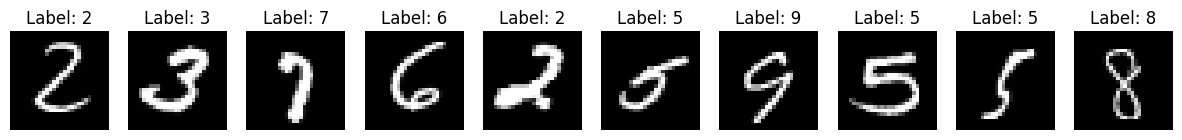

In [ ]:
# Hàm hiển thị một số hình ảnh chữ viết tay từ tập dữ liệu MNIST
def display_handwritten_digits(X, y, num_samples=10):
    idx = np.random.choice(X.shape[0], num_samples, replace=False)
    samples = X[idx].reshape((-1, 28, 28))  # Chuyển về dạng 28x28
    labels = y[idx]

    # Tạo plot
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Hiển thị dữ liệu chữ viết tay
display_handwritten_digits(X, y)

In [ ]:
# Hàm giảm chiều và đánh giá mô hình
def reduce_and_evaluate(reducer, X, y, param_value=None, n_components=2):
    if reducer == 'pca':
        model = PCA(n_components=n_components)
        X_reduced = model.fit_transform(X)
    elif reducer == 'lda':
        model = LDA(n_components=n_components)
        X_reduced = model.fit_transform(X, y)
    elif reducer == 'umap':
        model = umap.UMAP(n_components=2, n_neighbors=param_value, min_dist=0.1, random_state=42)
        X_reduced = model.fit_transform(X)
    elif reducer == 'tsne':
        model = TSNE(n_components=2, perplexity=param_value, random_state=42)
        X_reduced = model.fit_transform(X)

    # Huấn luyện và đánh giá
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return X_reduced, y, acc

In [ ]:
def tune_and_plot_accuracy(X, y, method, param_values):
    accuracies = []

    # Số lượng tham số cần tuning
    n_params = len(param_values)
    max_cols = 4  # Tối đa 4 biểu đồ trên mỗi hàng
    n_rows = (n_params + max_cols - 1) // max_cols  # Tính số hàng cần thiết

    # Tạo subplots
    fig, axes = plt.subplots(n_rows, max_cols, figsize=(5 * max_cols, 5 * n_rows))
    axes = axes.flatten()  # Chuyển axes thành mảng 1D để dễ truy cập
    if n_params < len(axes):  # Ẩn các ô thừa
        for ax in axes[n_params:]:
            ax.set_visible(False)

    for i, param in enumerate(param_values):
        if method == 'pca':
            X_reduced, _, acc = reduce_and_evaluate('pca', X, y, n_components=param)
            title = f"PCA (n_components = {param})"
        accuracies.append(acc)

        # Vẽ scatterplot nếu đủ số chiều
        if X_reduced.shape[1] >= 2:
            ax = axes[i]
            sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette="tab10", s=10, ax=ax, legend=False)
            ax.set_title(title)
            ax.set_xlabel("Component 1")
            ax.set_ylabel("Component 2")
        else:
            print(f"Cannot plot {method.upper()} with param = {param} because the result has only one dimension.")

    # Hiển thị tất cả subplots
    plt.tight_layout()
    plt.show()

    # Vẽ biểu đồ accuracy tuning
    plt.figure(figsize=(7, 5))
    plt.plot(param_values, accuracies, marker='o', linestyle='--')
    plt.title(f"Accuracy Tuning for {method.upper()}")
    plt.xlabel("Parameter Value")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Tuning PCA Hyperparameters...


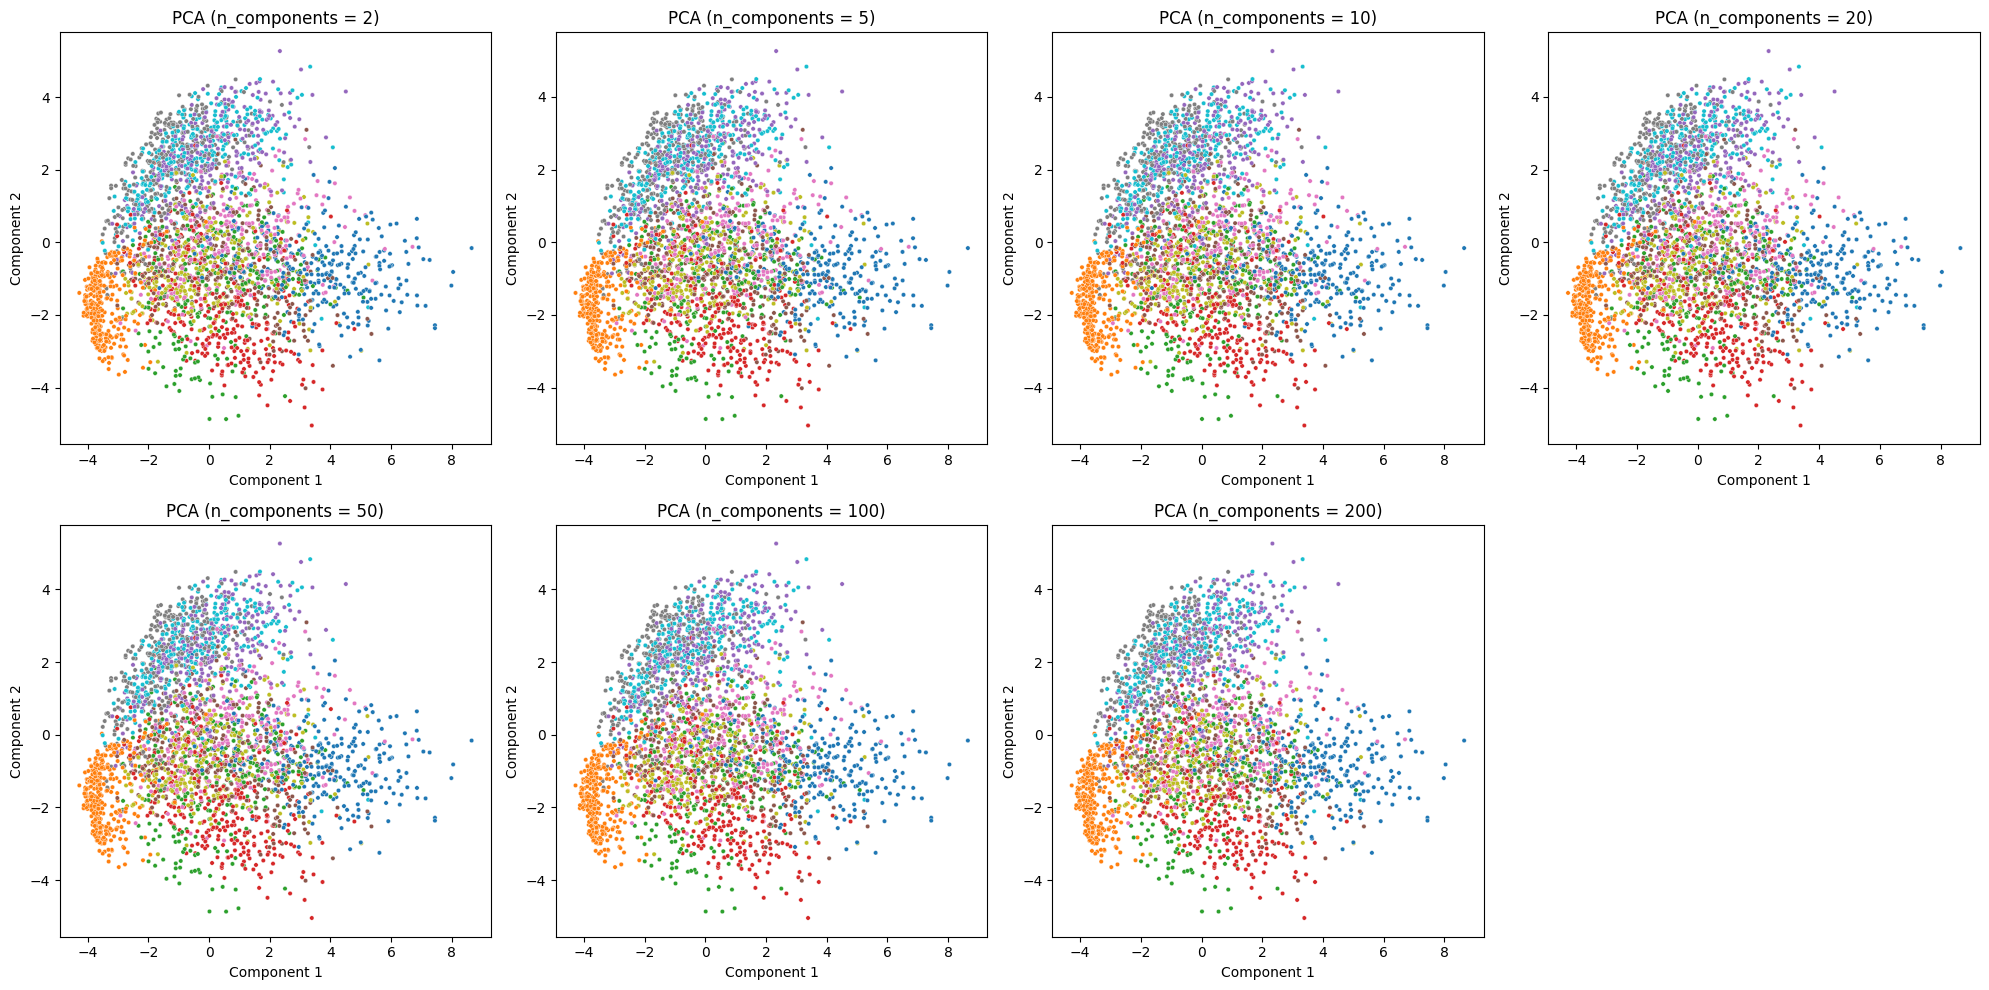

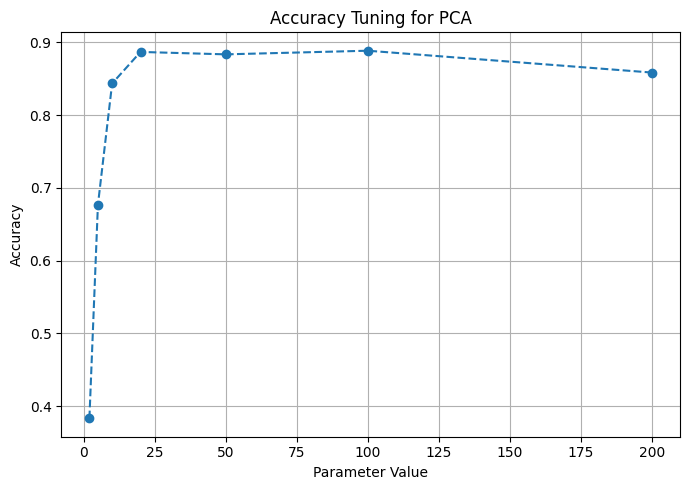

In [ ]:
print("\nTuning PCA Hyperparameters...")
tune_and_plot_accuracy(X, y, 'pca', param_values=[2, 5, 10, 20, 50, 100, 200])

In [ ]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Thêm thư viện OpenCV

# Đọc ảnh và chuyển sang grayscale
image = Image.open('/content/input_image.jpg').convert('L')

# Tăng độ tương phản để làm nổi bật nét chữ
enhancer = ImageEnhance.Contrast(image)
image = enhancer.enhance(3.0)

# Sử dụng OpenCV để tìm contours
open_cv_image = np.array(image)
contours, _ = cv2.findContours(open_cv_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])  # Giả sử contour lớn nhất là chữ số

# Cắt theo contour và resize
digit = open_cv_image[y:y+h, x:x+w]
digit = Image.fromarray(digit)
digit = digit.resize((20, 20), Image.LANCZOS)  # Resize chữ số để nhỏ hơn khung 28x28

# Căn giữa trong ảnh 28x28
final_image = Image.new('L', (28, 28), 255)  # Tạo ảnh nền trắng
final_image.paste(digit, (4, 4))  # Căn giữa chữ số trong khung 28x28

# Lưu và hiển thị kết quả
final_image.save('output_mnist_style.jpg')
plt.imshow(final_image, cmap='gray')
plt.title("Ảnh sau xử lý (chuẩn MNIST)")
plt.axis('off')
plt.show()

In [ ]:
#  DEMO
# Hàm tiền xử lý hình ảnh và dự đoán chữ số
def preprocess_and_predict(image_path, pca_model, clf_model):
    # Đọc hình ảnh và chuyển về dạng 28x28
    image = Image.open(image_path).convert('L')
    image = image.resize((28, 28))
    image_array = np.array(image)

    # Chuẩn hóa hình ảnh giống như dữ liệu MNIST (chia cho 255)
    image_array = image_array / 255.0

    # Chuyển thành dạng 1D (giống như dữ liệu MNIST)
    image_array = image_array.reshape(1, -1)

    # Sử dụng PCA để giảm chiều dữ liệu
    image_reduced = pca_model.transform(image_array)

    # Dự đoán chữ số sử dụng mô hình Random Forest đã huấn luyện
    predicted_label = clf_model.predict(image_reduced)

    return predicted_label[0]

# Khởi tạo dữ liệu MNIST và huấn luyện PCA + Random Forest
mnist = tf.keras.datasets.mnist
(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))  # Chuyển thành 2D
X_train = X_train / 255.0  # Chuẩn hóa dữ liệu

# Huấn luyện PCA và Random Forest
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)

# Chia tập dữ liệu để huấn luyện Random Forest
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_reduced, y_train)

# Dự đoán chữ số từ hình ảnh mới
image_path = '/content/output_mnist_style.jpg'  # Đường dẫn đến hình ảnh cần dự đoán
predicted_digit = preprocess_and_predict(image_path, pca, clf)

print(f"Predicted digit: {predicted_digit}")